#  Ujednolicanie klas w adnotacjach COCO

###  Opis
Notebook służy do **ujednolicania nazw klas** w plikach adnotacji COCO (`_annotations.coco.json`) 
dla różnych zbiorów danych dotyczących **detekcji obiektów pływających** (np. statków, łodzi, okrętów podwodnych).

Celem jest:
- przetworzenie wszystkich plików COCO w katalogu `datasets_coco`,  
- dopasowanie nazw klas do wspólnego słownika (`class_mapping`),  
- utworzenie zunifikowanych plików COCO oraz jednego zbiorczego pliku CSV.

###  Efekty działania
- `_annotations_unified.coco.json` – nowe pliki adnotacji z ujednoliconymi klasami,  
- `all_labels_unified.csv` – plik CSV zawierający wszystkie adnotacje i klasy,  
- statystyka liczby obiektów dla każdej klasy,  
- lista nieznanych klas wymagających dopisania do mapowania.

## Importy i ustawienia bazowe

In [1]:
import os
import json
import pandas as pd

# Ustawienia bazowe
base_dir = "datasets_coco"                                          # folder główny ze zbiorami COCO
output_csv = os.path.join(base_dir, "all_labels_unified.csv")       # plik wynikowy CSV

## Słownik mapowania klas

In [2]:
class_mapping = {
    # Military - Warships
    "aircraft carrier": ("Aircraft carrier", "Sea", "Military"),
    "carrier": ("Aircraft carrier", "Sea", "Military"),
    "lotniskowiec": ("Aircraft carrier", "Sea", "Military"),

    "niszczyciel rakietowy": ("Destroyer", "Sea", "Military"),
    "krazownik rakietowy": ("Cruise", "Sea", "Military"),
    "warship": ("Warship", "Sea", "Military"),
    "container-warship-ships-buoys": ("Warship", "Sea", "Military"),
    "przybrzezny okret bojowy": ("Warship", "Sea", "Military"),

    "okret desantowy": ("Landing ship", "Sea", "Military"),
    "uniwersalny okret desantowy": ("Landing ship", "Sea", "Military"),

    "okret podwodny": ("Submarine", "Sea", "Military"),
    "submarine": ("Submarine", "Sea", "Military"),

    # Civilian / Transport ships
    "cargo": ("Container ship", "Sea", "Transport/Civilian"),
    "container": ("Container ship", "Sea", "Transport/Civilian"),
    "container ship": ("Container ship", "Sea", "Transport/Civilian"),
    "tanker": ("Tanker", "Sea", "Transport/Civilian"),
    "cruise": ("Cruise", "Sea", "Civilian/Transport"),
    "ships": ("Civilian ship", "Sea", "Civilian/Military"),
    "vessel-z4gu": ("Civilian ship", "Sea", "Civilian/Military"),
    "civilianship": ("Civilian ship", "Sea", "Civilian"),
    "merchant_ship": ("Civilian ship", "Sea", "Transport/Civilian"),
    "barge": ("Barge", "Sea", "Transport/Civilian"),

    # Small civilian vessels
    "canoe": ("Canoe", "Sea", "Civilian"),
    "sail boat": ("Sail boat", "Sea", "Civilian"),
    "sailboat": ("Sail boat", "Sea", "Civilian"),
    "speedboat": ("Boat", "Sea", "Civilian/Military"),
    "fish-b": ("Fishing boat", "Sea", "Civilian"),
    "fishing_boat": ("Fishing boat", "Sea", "Civilian"),
    "yacht": ("Yacht", "Sea", "Civilian"),
    "boat": ("Boat", "Sea", "Civilian"),

    # Emergency / Coastguard
    "coastguard": ("Coastguard ship", "Sea", "Emergency/Military"),

    # Miscellaneous / Others
    "buoy": ("Buoy", "Sea", "Civilian"),
    "beacon": ("Container ship", "Sea", "Civilian"),
    "human-drowning": ("Human", "Sea", "Civilian"),
    "human-swimming": ("Human", "Sea", "Civilian"),
    "human-water": ("Human", "Sea", "Civilian"),
    "person": ("Human", "Sea", "Civilian"),
    "object": ("Unknown Object", "Sea", "Miscellaneous"),
    "object-detection": ("Unknown Object", "Sea", "Miscellaneous"),
    "bridge": ("Bridge", "Sea", "Infrastructure"),
    "ship": ("Ship", "Sea", "Civilian/Military"),

    # Nowe YOLO klasy (0–9) - numeric keys
    0: ("Aircraft carrier", "Sea", "Military"),
    1: ("Bulkers", "Sea", "Transport/Civilian"),
    2: ("Car carrier", "Sea", "Transport/Civilian"),
    3: ("Container ship", "Sea", "Transport/Civilian"),
    4: ("Cruise", "Sea", "Civilian/Transport"),
    5: ("Destroyer", "Sea", "Military"),
    6: ("Recreational", "Sea", "Civilian"),
    7: ("Boat", "Sea", "Civilian"),
    8: ("Submarine", "Sea", "Military"),
    9: ("Tug", "Sea", "Civilian"),
}

## Funkcja pomocnicza find_mapping -wyszukiwanie klas

In [3]:
def find_mapping(orig_raw):
    candidates = []
    if isinstance(orig_raw, int):
        candidates.extend([orig_raw, str(orig_raw), str(orig_raw).lower()])
    else:
        s = str(orig_raw).strip()
        if s.isdigit():
            candidates.append(int(s))
        candidates.extend([
            s, s.lower(),
            s.replace("_", " ").replace("-", " ").lower(),
            s.replace("_", "-").lower(),
            s.replace("-", "_").lower()
        ])
    for c in candidates:
        if c in class_mapping:
            return class_mapping[c]
    return None

In [ ]:
unified_categories = [
    {"id": i + 1, "name": name} for i, name in enumerate([
        "Aircraft carrier", "Bulkers", "Car carrier", "Container ship",
        "Cruise", "Destroyer", "Recreational", "Boat", "Submarine",
        "Tug", "Warship", "Landing ship", "Civilian ship", "Tanker",
        "Barge", "Canoe", "Sail boat", "Fishing boat", "Yacht",
        "Coastguard ship", "Buoy", "Human", "Unknown Object",
        "Bridge", "Ship"
    ])
]
name_to_id = {cat["name"]: cat["id"] for cat in unified_categories}

rows = []
unknown_orig_classes = set()
annotation_counter = 1  # aby każde ID adnotacji było unikalne globalnie

# Iteracja po zbiorach
for dataset_name in os.listdir(base_dir):
    dataset_path = os.path.join(base_dir, dataset_name)
    if not os.path.isdir(dataset_path):
        continue

    for split in ["train", "valid", "test"]:
        json_path = os.path.join(dataset_path, split, "_annotations.coco.json")
        if not os.path.exists(json_path):
            print(f"Brak pliku: {json_path}")
            continue

        with open(json_path, "r", encoding="utf-8") as f:
            coco = json.load(f)

        img_map = {img["id"]: img["file_name"] for img in coco.get("images", [])}
        cat_map = {cat["id"]: str(cat.get("name", "")).strip() for cat in coco.get("categories", [])}

        new_coco = {
            "info": coco.get("info", {}),
            "licenses": coco.get("licenses", []),
            "images": coco.get("images", []),
            "annotations": [],
            "categories": unified_categories
        }

        for ann in coco.get("annotations", []):
            image_file = img_map.get(ann["image_id"], "unknown")
            orig_raw = cat_map.get(ann["category_id"], "unknown")

            mapping = find_mapping(orig_raw)
            if mapping is not None:
                unified_class, category_of_movement, vehicle_type = mapping
                new_category_id = name_to_id.get(unified_class, 25)
            else:
                unified_class, category_of_movement, vehicle_type = ("Unknown Object", "Unknown", "Unknown")
                new_category_id = 23
                unknown_orig_classes.add(orig_raw)

            # Poprawne bbox i typy danych
            bbox = [float(x) for x in ann.get("bbox", [0, 0, 0, 0])]
            new_ann = {
                "id": annotation_counter,
                "image_id": int(ann.get("image_id", 0)),
                "category_id": int(new_category_id),
                "bbox": bbox,
                "area": float(ann.get("area", bbox[2] * bbox[3])),
                "iscrowd": int(ann.get("iscrowd", 0)),
                "segmentation": ann.get("segmentation", [])
            }
            new_coco["annotations"].append(new_ann)
            annotation_counter += 1

            image_path = os.path.abspath(os.path.join(dataset_path, split, image_file))
            rows.append({
                "dataset": dataset_name,
                "split": split,
                "image_file": image_file,
                "image_path": image_path,
                "original_class": orig_raw,
                "unified_class": unified_class,
                "category_of_movement": category_of_movement,
                "vehicle_type": vehicle_type,
                "bbox_x": bbox[0],
                "bbox_y": bbox[1],
                "bbox_width": bbox[2],
                "bbox_height": bbox[3],
            })

        new_json_path = os.path.join(dataset_path, split, "_annotations_unified.coco.json")
        with open(new_json_path, "w", encoding="utf-8") as f:
            json.dump(new_coco, f, indent=2, ensure_ascii=False)
        print(f" Utworzono plik COCO: {new_json_path}")

 Utworzono plik COCO: datasets_coco\universe_1\train\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_1\valid\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_1\test\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_2\train\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_2\valid\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_2\test\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_3\train\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_3\valid\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_3\test\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_4\train\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_4\valid\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_4\test\_annotations_unified.coco.j

In [6]:
# === Zapis CSV ===
if rows:
    df = pd.DataFrame(rows)
    columns = [
        "dataset", "split", "image_file", "image_path",
        "original_class", "unified_class", "category_of_movement", "vehicle_type",
        "bbox_x", "bbox_y", "bbox_width", "bbox_height"
    ]
    df = df[columns]
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"\n Zapisano CSV: {output_csv}")
    print(f"Liczba rekordów: {len(df)}")
    print(df.head(1))

if unknown_orig_classes:
    print(f"\n Nieznane klasy: {unknown_orig_classes}")
else:
    print("\n Wszystkie klasy poprawnie zmapowane.")


 Zapisano CSV: datasets_coco\all_labels_unified.csv
Liczba rekordów: 76823
      dataset  split                                         image_file  \
0  universe_1  train  100001419_bmp.rf.bae85e4419e82c5e7c8e18fc72b39...   

                                          image_path         original_class  \
0  c:\Users\Szymon\Desktop\Watercraft-detection\d...  niszczyciel rakietowy   

  unified_class category_of_movement vehicle_type  bbox_x  bbox_y  bbox_width  \
0     Destroyer                  Sea     Military    83.0    12.0        62.0   

   bbox_height  
0        161.0  

 Wszystkie klasy poprawnie zmapowane.


## Generowanie zestawienia liczby obiektów dla każdej klasy

In [7]:
summary = (
    df.groupby("unified_class")
      .size()
      .reset_index(name="object_count")
      .sort_values("object_count", ascending=False)
)
print("\n Liczba obiektów dla każdej klasy:")
print(summary.to_string(index=False))


 Liczba obiektów dla każdej klasy:
   unified_class  object_count
         Warship         12022
          Cruise         11112
    Fishing boat          8178
  Container ship          7225
       Sail boat          5978
   Civilian ship          5949
            Buoy          3941
            Boat          3468
           Canoe          3286
Aircraft carrier          2741
       Destroyer          2713
     Car carrier          2041
           Human          1923
       Submarine          1852
    Landing ship          1390
          Tanker          1268
             Tug           915
 Coastguard ship           328
    Recreational           263
         Bulkers           230


## Wyświetlenie listy nieznanych klas, które wymagają dopisania do class_mapping

In [8]:
if unknown_orig_classes:
    print("\n Nieznane oryginalne klasy (do dopisania w class_mapping):")
    for u in sorted(unknown_orig_classes):
        print(" -", repr(u))
else:
    print("\n  Wszystkie klasy zmapowane poprawnie.")


  Wszystkie klasy zmapowane poprawnie.


## Statyskyki klas

 Podsumowanie liczby obiektów w klasach (Train / Valid / Test / Suma):

   unified_class  test  train  valid  total
Aircraft carrier   184   2224    333   2741
            Boat   303   2354    811   3468
         Bulkers    11    200     19    230
            Buoy   104   3612    225   3941
           Canoe   432   2148    706   3286
     Car carrier    90   1772    179   2041
   Civilian ship  1743   3010   1196   5949
 Coastguard ship    26    236     66    328
  Container ship   397   6124    704   7225
          Cruise   535   9530   1047  11112
       Destroyer    94   2394    225   2713
    Fishing boat   355   7211    612   8178
           Human   183   1333    407   1923
    Landing ship    54   1229    107   1390
    Recreational    16    236     11    263
       Sail boat   435   4627    916   5978
       Submarine    95   1542    215   1852
          Tanker    82   1029    157   1268
             Tug    35    803     77    915
         Warship  1823   8454   1745  12022

 Łą

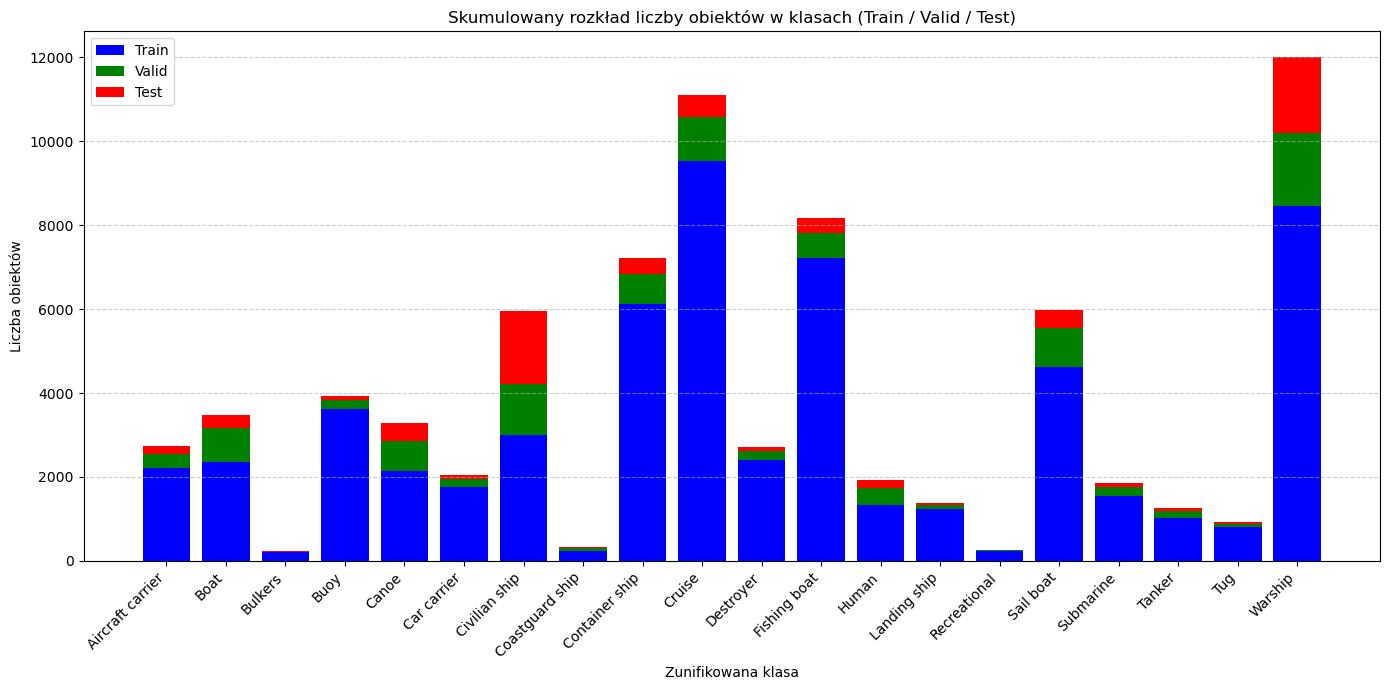

In [ ]:
import matplotlib.pyplot as plt

# Grupowanie danych po klasie i zbiorze
split_summary = (
    df.groupby(["unified_class", "split"])
      .size()
      .unstack(fill_value=0)
      .reset_index()
)

# Dodanie kolumny sumy
split_summary["total"] = split_summary[["train", "valid", "test"]].sum(axis=1)

# Wyświetlenie tabeli podsumowującej
print(" Podsumowanie liczby obiektów w klasach (Train / Valid / Test / Suma):\n")
print(split_summary.to_string(index=False))

# Całkowita liczba obiektów
total_objects = split_summary["total"].sum()
print(f"\n Łączna liczba wszystkich obiektów: {total_objects}")

# Wykres słupkowy skumulowany
plt.figure(figsize=(14, 7))

# Pozycje słupków
x = range(len(split_summary))

# Rysowanie skumulowanych słupków
plt.bar(x, split_summary["train"], color='blue', label='Train')
plt.bar(x, split_summary["valid"], bottom=split_summary["train"], color='green', label='Valid')
plt.bar(
    x,
    split_summary["test"],
    bottom=split_summary["train"] + split_summary["valid"],
    color='red',
    label='Test'
)

# Opisy osi i legenda
plt.xticks(x, split_summary["unified_class"], rotation=45, ha='right')
plt.xlabel("Zunifikowana klasa")
plt.ylabel("Liczba obiektów")
plt.title("Skumulowany rozkład liczby obiektów w klasach (Train / Valid / Test)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Sprawdzenie liczby adnotacji w każdym zbiorze danych

In [ ]:
import pandas as pd

# Tabela: Liczba unikalnych obrazów w każdym zbiorze danych
dataset_stats_images = []

for dataset_name in df["dataset"].unique():
    df_dataset = df[df["dataset"] == dataset_name]
    train_count = df_dataset[df_dataset["split"] == "train"]["image_file"].nunique()
    valid_count = df_dataset[df_dataset["split"] == "valid"]["image_file"].nunique()
    test_count  = df_dataset[df_dataset["split"] == "test"]["image_file"].nunique()
    total_count_dataset = train_count + valid_count + test_count

    dataset_stats_images.append({
        "dataset": dataset_name,
        "train": train_count,
        "valid": valid_count,
        "test": test_count,
        "total": total_count_dataset
    })

df_dataset_stats_images = pd.DataFrame(dataset_stats_images)

# Dodanie kolumn procentowych
df_dataset_stats_images["train_%"] = (df_dataset_stats_images["train"] / df_dataset_stats_images["total"] * 100).round(2)
df_dataset_stats_images["valid_%"] = (df_dataset_stats_images["valid"] / df_dataset_stats_images["total"] * 100).round(2)
df_dataset_stats_images["test_%"]  = (df_dataset_stats_images["test"] / df_dataset_stats_images["total"] * 100).round(2)

print("\nTabela: Liczba unikalnych obrazów w poszczególnych datasetach (Train / Valid / Test / Total / % udział):\n")
print(df_dataset_stats_images.to_string(index=False))


# Całkowita liczba wszystkich obrazów i udział %
total_images_all = df_dataset_stats_images[["train", "valid", "test", "total"]].sum()
total_train_pct = total_images_all["train"] / total_images_all["total"] * 100
total_valid_pct = total_images_all["valid"] / total_images_all["total"] * 100
total_test_pct  = total_images_all["test"] / total_images_all["total"] * 100

print("\nŁączna liczba wszystkich unikalnych obrazów we wszystkich datasetach:\n")
print(total_images_all)
print(f"\nProcentowy udział: Train: {total_train_pct:.2f}%, Valid: {total_valid_pct:.2f}%, Test: {total_test_pct:.2f}%")



Tabela: Liczba unikalnych obrazów w poszczególnych datasetach (Train / Valid / Test / Total / % udział):

   dataset  train  valid  test  total  train_%  valid_%  test_%
universe_1   2246    221   100   2567    87.50     8.61    3.90
universe_2   5294   1671   927   7892    67.08    21.17   11.75
universe_3   4906    800   400   6106    80.35    13.10    6.55
universe_4  19746   1354   680  21780    90.66     6.22    3.12
universe_5   4048   1636  2311   7995    50.63    20.46   28.91
universe_7   7107    657   359   8123    87.49     8.09    4.42

Łączna liczba wszystkich unikalnych obrazów we wszystkich datasetach:

train    43347
valid     6339
test      4777
total    54463
dtype: int64

Procentowy udział: Train: 79.59%, Valid: 11.64%, Test: 8.77%


## Sprawdzenie poprawności plików obrazów

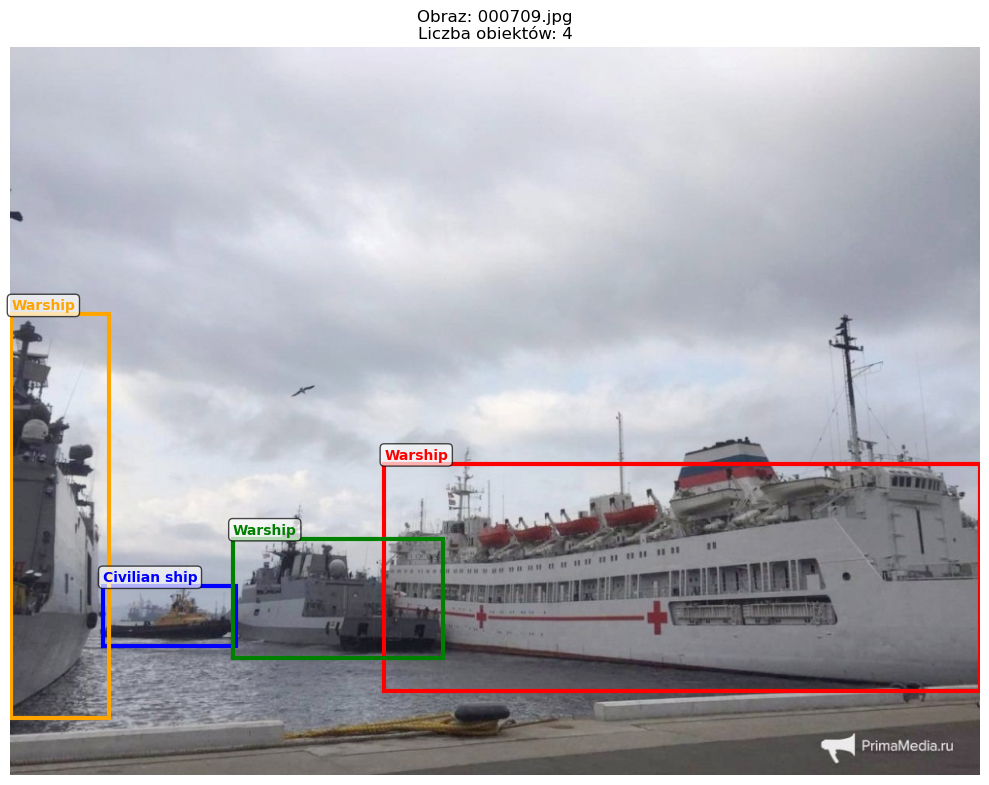

Dataset: universe_5 | Split: train
Plik: 000709.jpg
Liczba obiektów: 4

Obiekty:
  1. Warship (bbox: 385, 429, 614, 234)
  2. Civilian ship (bbox: 95, 555, 137, 62)
  3. Warship (bbox: 229, 506, 216, 123)
  4. Warship (bbox: 1, 275, 100, 416)


In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

random_image_path = random.choice(df['image_path'].unique())

# Pobieranie wszystkich obiektów dla tego obrazu
image_objects = df[df['image_path'] == random_image_path]
row = image_objects.iloc[0]

# Wczytanie obrazu
image = Image.open(row['image_path'])

# Wyświetlenie
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(image)

# Wszystkie bboxy
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']
for i, (idx, obj) in enumerate(image_objects.iterrows()):
    bbox = [obj['bbox_x'], obj['bbox_y'], obj['bbox_width'], obj['bbox_height']]
    color = colors[i % len(colors)]
    
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                            linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    
    # Etykiety z nazwami klas
    ax.text(bbox[0], bbox[1]-5, obj['unified_class'], 
            color=color, fontweight='bold', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

ax.set_title(f"Obraz: {row['image_file']}\nLiczba obiektów: {len(image_objects)}")
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Dataset: {row['dataset']} | Split: {row['split']}")
print(f"Plik: {row['image_file']}")
print(f"Liczba obiektów: {len(image_objects)}")
print("\nObiekty:")
for i, (idx, obj) in enumerate(image_objects.iterrows()):
    print(f"  {i+1}. {obj['unified_class']} (bbox: {obj['bbox_x']:.0f}, {obj['bbox_y']:.0f}, {obj['bbox_width']:.0f}, {obj['bbox_height']:.0f})")